In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from tqdm import tqdm
from p_tqdm import p_map

import os
import shutil

import networkx as nx

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
from rdkit import DataStructs
rdDepictor.SetPreferCoordGen(True)
#from rdkit import RDLogger
#RDLogger.DisableLog('rdApp.warning')

from molvs import standardize_smiles

import pubchempy 

RDKit WARNING: [15:42:54] Enabling RDKit 2019.09.2 jupyter extensions


# Repurposed small-molecule drugs for COVID

The following list is from the recent article by Liu et al [1]. 

![](images/covid_drugs_from_article.png)

[1. C. Liu, Q. Zhou, Y. Li, L. V. Garner, S. P. Watkins, L. J. Carter, J. Smoot, A. C. Gregg, A. D. Daniels, S. Jervey, D. Albaiu, Research and Development on Therapeutic Agents and Vaccines for COVID-19 and Related Human Coronavirus Diseases. ACS Cent. Sci. (2020)](https://doi.org/10.1021/acscentsci.0c00272)

In [2]:
df = pd.read_csv("covid_drugname_cas.csv", delimiter="\t")
df

,name,cas_id
0,Baricitinib,1187594-09-7
1,Lopinavir,192725-17-0
2,Ritonavir,155213-67-5
3,Darunavir,206361-99-1
4,Favipiravir,259793-96-9
5,Remdesivir,1809249-37-3
6,Ribavirin,36791-04-5
7,Galidesivir,249503-25-1
8,Arbidol,131707-23-8
9,Chloroquine,1954-05-07


In [3]:
def name2smiles(name):
    """
    Uses pubchempy to fetch the smiles of a molecule, given its name. 
    """
    pubchem_compounds = pubchempy.get_compounds(name, "name")
    try:
        return pubchem_compounds[0].isomeric_smiles
    except:
        return None

In [4]:
df["smiles"] = df["name"].map(name2smiles)

In [2]:
#df.to_csv("mols_w_smiles.csv")
df = pd.read_csv("mols_w_smiles.csv", index_col=0)

In [3]:
PandasTools.AddMoleculeColumnToFrame(df, smilesCol="smiles", molCol="rdmol")

In [4]:
df.rdmol.map(rdDepictor.Compute2DCoords)
img = Draw.MolsToGridImage(df.rdmol,molsPerRow=3,subImgSize=(400,400),legends=list(df.name))

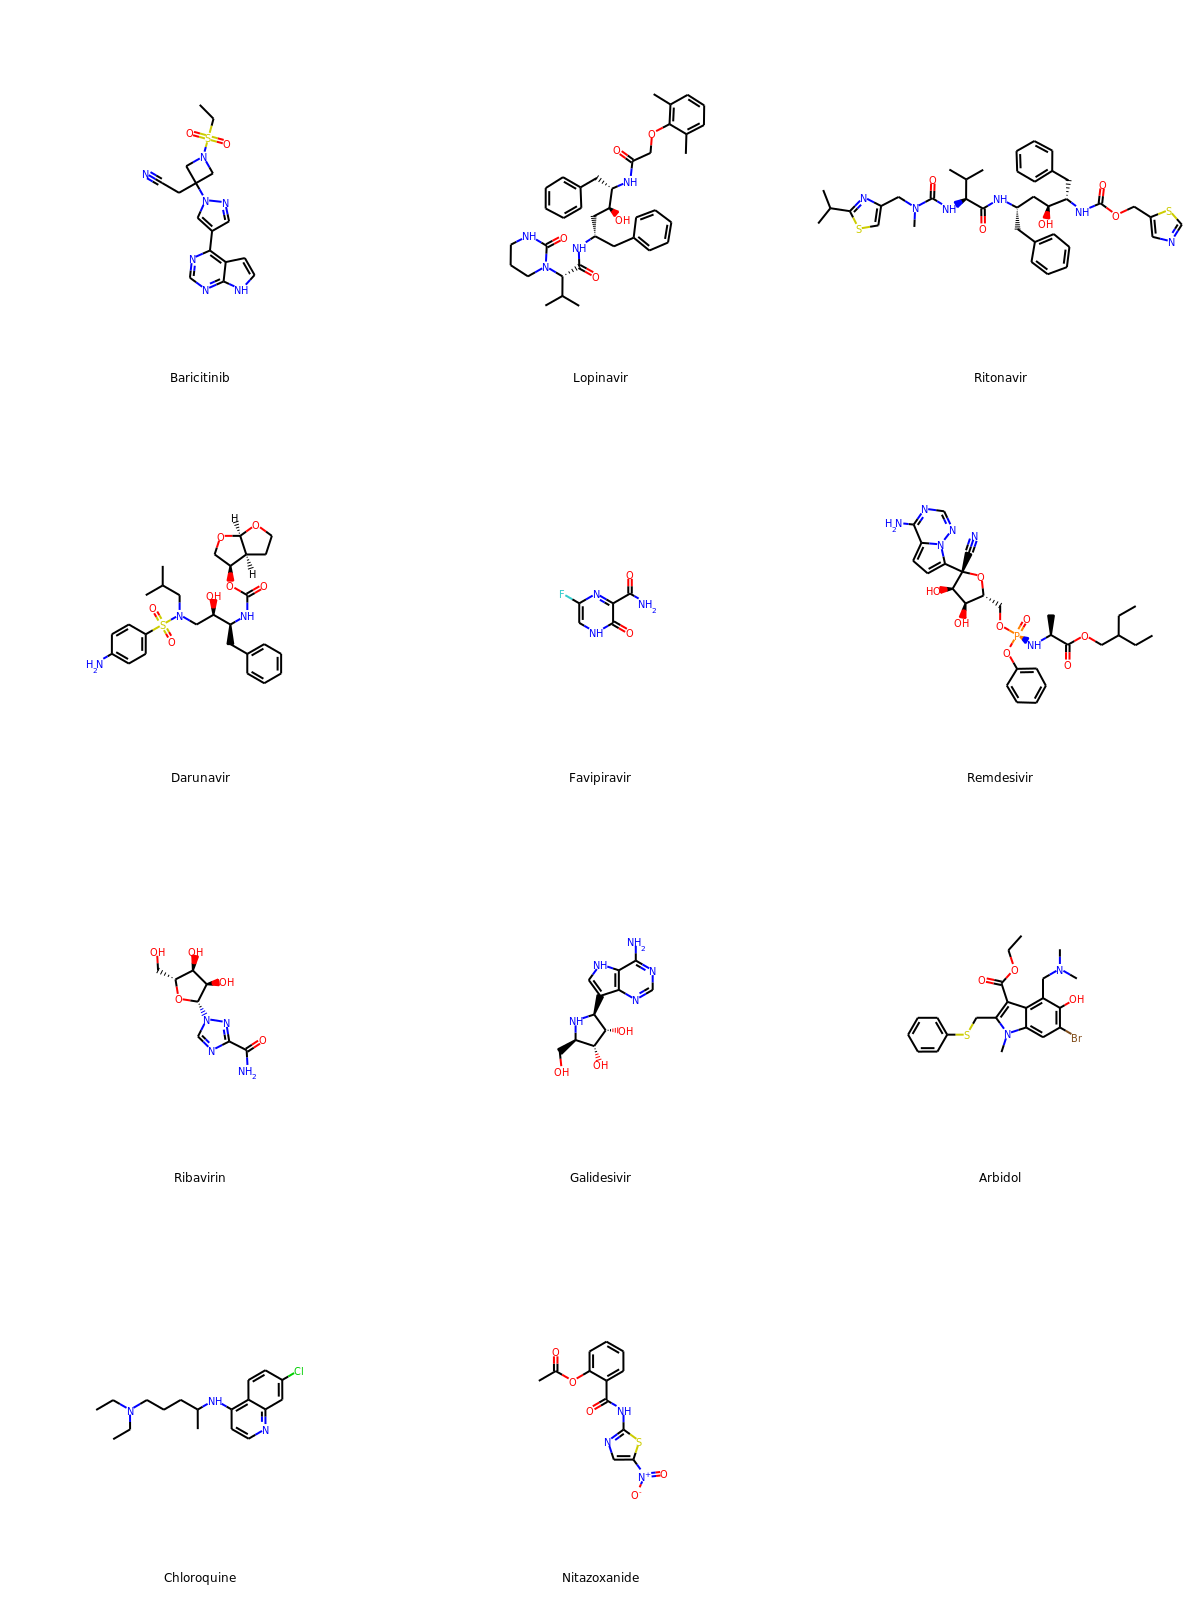

In [5]:
img

In [13]:
img.save("images/liu_article_antivirals.png")


In [ ]:
for i,r in df.iterrows():
    molname=r["name"]
    im = Draw.MolsToGridImage([r.rdmol])
    im.save(f"images/{molname}.png")

# 3D structure generation

- Some of these compounds have quite many rotatable bonds..
- [Here](https://pubs.acs.org/doi/10.1021/acs.jpcb.5b12272) they studied the conformational energy landscape of ritonavir, the one with most rotbonds
    - Structural to stabilize the bioactive conf? Like in [here](http://dx.doi.org/10.1021/acs.molpharmaceut.9b00437). Probably has been studied, no idea


In [14]:
df["nrotbonds"] = df.rdmol.map(rdMolDescriptors.CalcNumRotatableBonds)
df[["name", "nrotbonds"]]

,name,nrotbonds
0,Baricitinib,5
1,Lopinavir,15
2,Ritonavir,17
3,Darunavir,11
4,Favipiravir,1
5,Remdesivir,13
6,Ribavirin,3
7,Galidesivir,2
8,Arbidol,7
9,Chloroquine,8


# Similarity searches

- Downloaded the Pubchem database (107 million molecules)
    - ```wget ftp://ftp.ncbi.nlm.nih.gov/pubchem/Compound/Extras/CID-SMILES.gz```
- 6GB when uncompressed, can't read it to my memory directly. Split it to 1e5 row chuncks
    - ```split -l 100000 -d CID-SMILES```
    
- The following (trivially parallelizable) problem would have taken 14 hours with my crappy laptop, sent it to our remote cluster


In [4]:
# pubchem_smiles = [f for f in os.listdir() if f.startswith("x")]
# with open("already_looked") as f: already_looked = [i.strip() for i in f.readlines()]
# not_looked = list(set(pubchem_smiles).difference(set(already_looked)))

# fps_antivirals = [Chem.RDKFingerprint(m) for m in df.rdmol]

# def compute_similarities_for_chunk(path_to_cid_smiles):
#     def smiles_to_simvec(smiles):
#         rdmol=Chem.MolFromSmiles(smiles)
#         fp2compare = Chem.RDKFingerprint(rdmol)
#         sims = []
#         for fp_i in fps_antivirals:
#             try:
#                 sim = DataStructs.FingerprintSimilarity(fp2compare,fp_i) 
#             except:
#                 sim = None
#             sims.append(sim)
#         return sims
    
#     res = []
#     with open(path_to_cid_smiles) as f:
#         cid_smiles = f.readlines()
#     for r in cid_smiles:
#         try:
#             sims = smiles_to_simvec(r.split()[1])
#             res.append(",".join(r.split()) + "," + ",".join([str(i) for i in sims]))
#         except:
#             continue
#     with open(f"sims_{path_to_cid_smiles}", "w") as f:
#         f.write("\n".join(res))
#     with open(f"already_looked", "a") as f:
#         f.write(f"{path_to_cid_smiles}\n")
# p_map(compute_similarities_for_chunk, not_looked, num_cpus=4)

#

# cols = ["cid", "smiles"] + list(df.name)

# dfz = {i : [] for i in df.name}
# with open("already_looked") as f: 
#     already_looked = f.readlines()
# for i in already_looked:
    
#     df_chunk = pd.read_csv(f"sims_{i}".strip(), names=cols)
#     for drugname in df.name:
#         sims = df_chunk[df_chunk[drugname] >= 0.7][["cid", "smiles", drugname]].to_numpy().tolist()
#         if len(sims)>0:
#             dfz[drugname]+=sims
            
# drugsim_dfs = {k : pd.DataFrame(v, columns="cid smiles similarity".split()).set_index("cid").sort_values("similarity", ascending=False)  for k,v in dfz.items()}

# for k,v in drugsim_dfs.items():  
#     v.to_csv(f"{k}_sims.csv")

- The molecules that have a Tanimoto similarity > 0.7 (RDKit topological fingerprints) are in ./similar_mols/<molecule>_sims.csv 
    - cid, smiles, similarity coefficient

In [84]:
mol_sims_dict = {molname : pd.read_csv(f"similar_mols/{molname}_sims.csv") for molname in df.name}

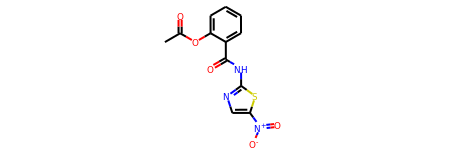

In [110]:
im = Draw.MolToImage(df[df.name == k].rdmol.values[0])

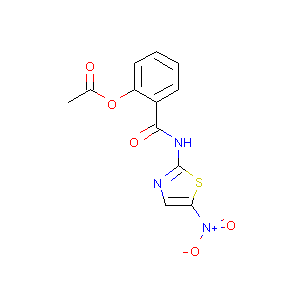

In [111]:
im

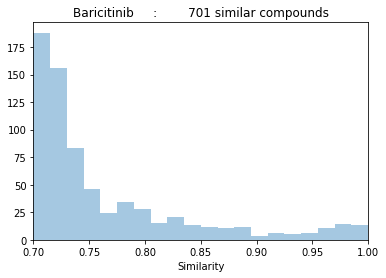

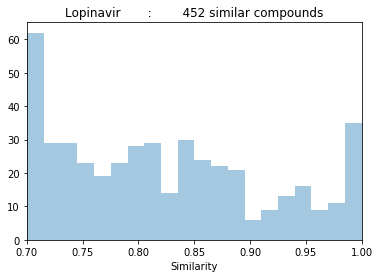

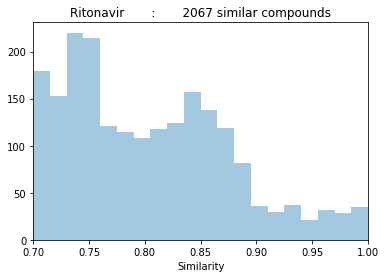

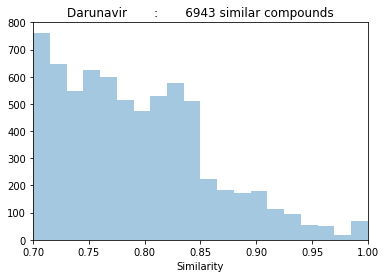

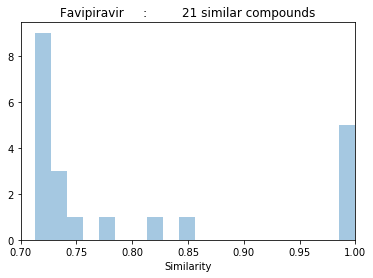

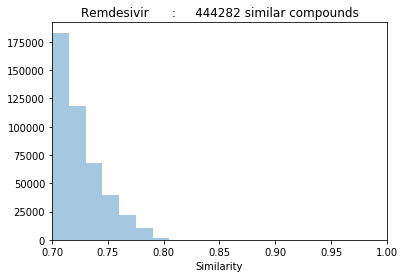

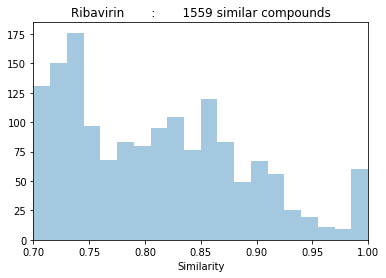

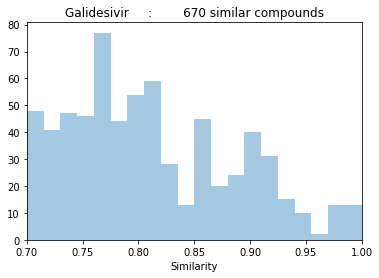

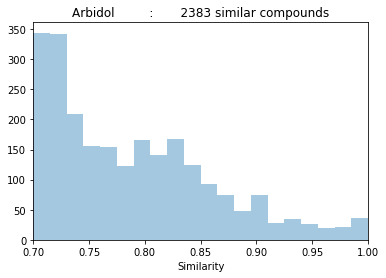

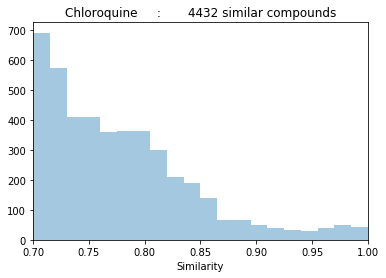

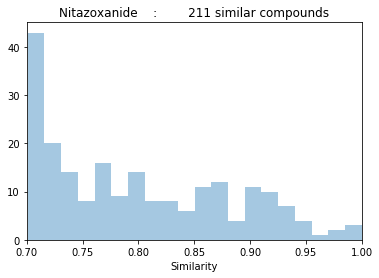

In [123]:
for k, v in mol_sims_dict.items():
    plt.figure()
    sns.distplot(v["similarity"], bins=20, kde=False)
    plt.xlim((0.7,1))
    plt.title(f"{k:15} : {v.shape[0]:10} similar compounds")
    plt.xlabel("Similarity")
    plt.savefig(f"images/{k}_sim.png")
    plt.show()


In [149]:
for i in df.name:
    url="https://github.com/mrauha/covid19_drugs/blob/master/images/"
    
    string = f'![{i}_mol]({url  + i}.png) ![{i}_dist]({url  + i}_sims.png)'
    print(string)

![Baricitinib_mol](https://github.com/mrauha/covid19_drugs/blob/master/images/Baricitinib.png) ![Baricitinib_dist](https://github.com/mrauha/covid19_drugs/blob/master/images/Baricitinib_sims.png)
![Lopinavir_mol](https://github.com/mrauha/covid19_drugs/blob/master/images/Lopinavir.png) ![Lopinavir_dist](https://github.com/mrauha/covid19_drugs/blob/master/images/Lopinavir_sims.png)
![Ritonavir_mol](https://github.com/mrauha/covid19_drugs/blob/master/images/Ritonavir.png) ![Ritonavir_dist](https://github.com/mrauha/covid19_drugs/blob/master/images/Ritonavir_sims.png)
![Darunavir_mol](https://github.com/mrauha/covid19_drugs/blob/master/images/Darunavir.png) ![Darunavir_dist](https://github.com/mrauha/covid19_drugs/blob/master/images/Darunavir_sims.png)
![Favipiravir_mol](https://github.com/mrauha/covid19_drugs/blob/master/images/Favipiravir.png) ![Favipiravir_dist](https://github.com/mrauha/covid19_drugs/blob/master/images/Favipiravir_sims.png)
![Remdesivir_mol](https://github.com/mrauha/

In [147]:
string

'![Nitazoxanide_mol](https://github.com/mrauha/covid19_drugs/blob/master/images/Nitazoxanide.png "Nitazoxanide") ![Nitazoxanide_dist](https://github.com/mrauha/covid19_drugs/blob/master/images/Nitazoxanide_sims.png)'